In [2]:
using LinearAlgebra
using Distributions
using BenchmarkTools

function randmatrix(n::Int64, m::Int64)
    p = Float64(m)/Float64(n)^2 #Calculates success rate
    M = rand(Bernoulli(p), n, n) #Creates n×n bernoulli matrix (0 and 1s)
    N = rand(Uniform(-1,1), n, n) #Creates n×n matrix with values random between -1 and 1
    for i = 1:n
        for j = 1:n
            if M[i,j] == 0
                N[i,j] = 0.0 #If value in M is 0, corresponding value in N is changed to 0.0, otherwise, do nothing
            end
        end
    end
    return N
end

function house(M::Matrix{Float64}, m::Int64)
    n = size(M,1) #Gets size of M (assumes matrix is square)
    A = copy(M) #Initialises copy of M
    for i = 1:m
        A = A[1:n-i+1 .!= 1,: ] #Removes first m rows
    end
    a = A[:,m] #Extracts mth column (with only n-m elements now)
    e = I[1:(n-m), 1] #Creates vector with n-m elements, leading with 1 and all other elements 0
    w = a - norm(a)*e #Calculates w
    P = Float64.(Matrix(I, n-m, n-m)) - (2w*(w'))/(norm(w)^2) #Calculates householder matrix P
    U = Float64.(Matrix(I, n, n)) #Initialises identity matrix
    for i = 1:n-m
        for j = 1:n-m
            U[i+m,j+m] = P[i,j] #Extends P to n×n dimensions by inserting P into the bottom right corner of an identity matrix
        end
    end
    return U #Returns householder transformation U
end

function hessen(M::Matrix{Float64})
    A = copy(M) #Initialises copy of M
    n = size(A,1) #Gets size of A (assumes square)
    for i = 1:n-2
        U = house(A, i) #Recursively generates householder transformation
        A = U*A*(U') #Applies transformation to A (uses conjugate transpose to retain similarity)
    end
    return A #Returns hessenberg matrix A
end 

function given(a::Float64, b::Float64)
    u = (a^2 + b^2)^0.5 #Calculates norm of vector [a b]
    c = a/u #Calculates c
    s = -b/u #Calculates s
    G = [c -s; s c] #Calculates Givens Rotation G
    return G #Returns G
end

function hessenqrdecomp(M::Matrix{Float64})
    A = copy(M)
    n = size(A,1) #Gets dimension of matrix (assumes it's square)
    
    for i = 1:n-1 #As Givens rotations are 2×2 matrixs, we only need to do n-1, not n, iterations
        a = A[i,i] #Extract arguements for given function
        b = A[i+1,i]
        G = given(a, b) #Creates Givens Rotation
        F = Float64.(Matrix(I, n, n)) #Initialises n×n identity matrix
        F[i,i], F[i,i+1], F[i+1,i], F[i+1,i+1] = G[1,1], G[1,2], G[2,1], G[2,2] #Inserts Givens Rotation along the diagonal
        A = F*A #Applies Givens Rotation to A
    end
    R = A #Calculates R
    Q = M*(R^-1) #Calculates Q 
    return Q, R #Return QR form
end

function extracteigen(M::Matrix{Float64}, n::Int, ϵ::Float64) #n is the dimensions of matrix, ϵ is error tolerance
    Eigen = zeros(Complex{Float64}, n) #Initialises vector of n eigenvalues
    M = ComplexF64.(M) #Converts matrix into complex form
    for i = 1:n #Recursively checks over all the leading diagonal
        Eigen[i] = M[i,i] #By defualt, the Eigenvalue is taken from the diagonal
        if i < n #Check to prevent index M[i+1,i] from exceeding bounds of n×n matrix
            if abs(M[i+1,i]) > ϵ #Checks if value immediately below the ith diagonal element is non-zero 
                a, b, c, d = M[i,i], M[i,i+1], M[i+1,i], M[i+1,i+1] #Extracts values of 2×2 matrix
                λ = (a + d + ((a + d)^2 -4*(a*d - b*c))^0.5)/2 #Calculates eigenvalue. This one takes the positive imaginary
                                                               #solution, we can see below that this eigenvalue pair will be
                                                               #picked up again by i+1, in which case will assign the negative
                                                               #imaginary solution
                Eigen[i] = λ #Assigns Eigenvalue as being λ
            end
        end
        if i > 1 #Similar check as above, prevents M[i,i-1] from exceeding bounds of n×n matrix
            if abs(M[i,i-1]) > ϵ #Checks if value immediately to the left of the ith diagonal element is non-zero
                                 #Note that this element is still below the diagonal
                a, b, c, d = M[i-1,i-1], M[i-1,i], M[i,i-1], M[i,i] #Extracts values of 2×2 matrix
                λ = (a + d - ((a + d)^2 -4*(a*d - b*c))^0.5)/2 #Calculates eigenvalue, As the positive imaginary solution was
                                                               #picked on the previous iteration, we take the negative
                                                               #imaginary solution
                Eigen[i] = λ #Assigns Eigenvalue as being λ
            end
        end
    end
    return Eigen #Returns list of Eigenvalues
end

function hessenqralgorithm(M::Matrix{Float64})
    A = hessen(M)
    n = size(A,1) #Gets dimension of matrix
    ϵ = 1e-5 #Error term (used to check when algorithm should terminate)
    Q, R = hessenqrdecomp(A) #Calculates QR form of matrix A using hessenberg reduction
    newA = R*Q #Calculates next A in sequence by reversing order of QR form
    newQ, newR = hessenqrdecomp(newA) #Calculates QR form of this new matrix
    while all(diag(abs.(newA - A) .< ϵ)) == false #checks if the diagonal (eigenvalues) of the newA and A are all
                                                  #within ϵ of each other and continues iterating if they are not
        A, Q, R = newA, newQ, newR #Updates A, Q, and R to be new values
        newA = R*Q #Calculates next A in sequence by reversing order of QR form
        newQ, newR = hessenqrdecomp(newA) #Calculates QR form of this this new matrix     
    end
    Eigen = extracteigen(newA, n, ϵ) #Generates list of eigenvalues of orginal matrix (they are the diagonals of newA)
    return Eigen #Returns eigenvalues
end

hessenqralgorithm (generic function with 1 method)

In [5]:
o = []
time = []
for i in 2:10                                          #Set the n-size of matrix
    print("Processing ",i,"x",i)                          #Shows progress of fun
    a = randmatrix(i,i^2)                                   #Generate random matrix
    t = @benchmark hessenqralgorithm($a) samples=10 evals=1
    push!(o,i)                                            #Fill the list with n-values for x-axis plotting
    push!(time, mean(t).time)                             #Fill the list with mean runtime of function for given n-size matrix
end

Processing 2x2Processing 3x3Processing 4x4

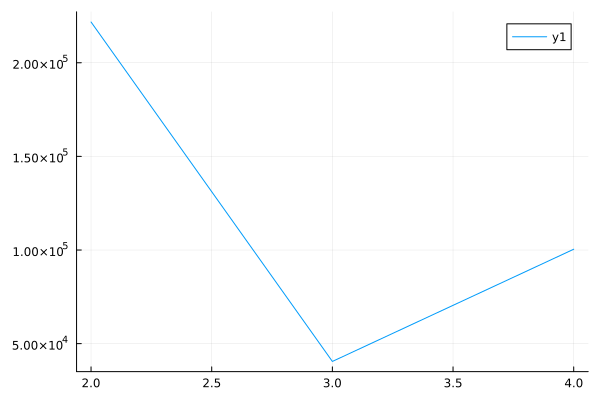

In [6]:
using Plots
plot(o,time)